# Идея

$$F(t) = m \cdot x'' + 2 \cdot m \cdot \delta \cdot x' + w_0^2 \cdot m \cdot x $$

где F(t) — сила(пусть пока известная и константная, например $sin(\Omega t)$.

У такого маятника решение описано [тут](https://mipt.ru/education/chair/physics/S_I/method/Meh_col.pdf) в части 3.3.

Пусть мы знаем фазу и амплитуду реальной системы (формула 31 на стр. 25) и мы хотим настроить параметры $\delta$ и $m$ так чтобы они совпадали для нашей системы и симулятора.

Тогда контроллер принимает следующие вещи: ($\Omega$, $t$, $m$, $\delta$, $w_0$, $x$, $x'$), а выдаёт ($m$, $\delta$), которые бы минимизировали разницу фазы и амплитуды между реальной системой и симулятором.

In [1]:
%matplotlib inline
import numpy as np, matplotlib.pyplot as plt, glob, os
import random
import torch
from collections import deque

import gym
from gym import error, spaces, utils
from gym.utils import seeding

In [2]:
from ddpg_agent import Agent

### Env

In [3]:
class PendulumEnv(gym.Env):
    def __init__(self, big_b=1, big_omega=1, theta=0,
                 m=1, k=0.1, beta=0.02, big_f_0=1,
                 n_steps=100, t_min=0, t_max=10):
        """
        Args:
            big_b (float): амплитуда.
            big_omega (float): частота.
            theta (float): фаза.
            m (float): масса грузика.
            k (float): жесткость пружины. 
            beta (float): коэф сопротивления среды.
            big_f_0 (float): ????.
            n_steps (int): количество шагов до завершения среды.
            t_min, t_max (float): min and max time.
        """
        
        # init
        self.initial_params = locals().copy()
        del self.initial_params['self']
        
        # system params
        self.big_b = big_b
        self.big_omega = big_omega
        self.theta = theta
        self.m = m
        self.k = k
        self.beta = beta
        self.big_f_0 = big_f_0
        
        self.delta = self.beta / (2 * self.m)
        self.omega_0 = self.k / self.m
        
        # RL params
        self.n_steps = n_steps
        self.t_min, self.t_max = t_min, t_max
        self._randomize_t()
        self.i = 0
        self.state_space = self._dc_input().shape[0]
        self.observation_space = spaces.Box(low=-10, high=10, shape=(self.state_space,), dtype=np.float32)
        # m, delta, big_omega
        self.action_space = spaces.Box(np.array([0,-2,-.1]), np.array([+10,+2,+.1]), dtype=np.float32)

        
    def _system(self, t=None):
        """Returns the real system position (f.31)."""
        if t is None:
            t = self.t
        return self.big_b * np.cos(self.big_omega * t - self.theta)
    
    def _x(self, t):
        return self._system(t)
    
    def _x_first_deriv(self, t):
        return - self.big_b * self.big_omega * np.sin(self.big_omega * t - self.theta)
    
    def _x_second_deriv(self, t):
        return - self.big_b * (self.big_omega**2) * np.cos(self.big_omega * t - self.theta)
    
    def _system_model(self, m, delta, big_omega, t=None):
        """Returns the model position."""
        if t is None:
            t = self.t
        big_b = self._big_b_model(m, delta, big_omega)
        theta = self._theta_model(m, delta, big_omega)
        return big_b * np.cos(big_omega * t - theta)
    
    def _dc_input(self, t=None):
        if t is None:
            t = self.t
#         return np.array([
# #             self.big_omega,
#             t,
# #             self.m,
# #             self.delta,
#             self.omega_0,
#             self._x(t),
#             self._x_first_deriv(t),
#         ])

        return np.array([
            self.big_omega,
#             t,
            self.m,
            self.delta,
#             self.omega_0,
#             self._x(t),
#             self._x_first_deriv(t),
        ])
    
    def _randomize_t(self):
#         self.t = np.random.uniform(self.t_min, self.t_max)
        t_space = np.arange(10)
        self.t = np.random.choice(t_space)
        
    def _big_b_model(self, m, delta, big_omega):
        omega_0_sqr = self.k / m
        f_0 = self.big_f_0 / m
        
        res = (omega_0_sqr**2 - big_omega**2)**2
        res += 4 * delta**2 * big_omega**2
        res = f_0 / res**0.5
        return res
    
    def _theta_model(self, m, delta, big_omega):
        omega_0_sqr = self.k / m
        
        res = 2 * delta * big_omega
        res /= omega_0_sqr - big_omega**2
        return res

    def step(self, action):

        # state
        self.i += 1

        # reward
        m_, delta_, big_omega_ = tuple(action)
        big_b_ = self._big_b_model(m_, delta_, big_omega_)
        theta_ = self._theta_model(m_, delta_, big_omega_)
        
        reward = 0
        reward -= (self.big_b - big_b_) ** 2
        reward -= (self.theta - theta_) ** 2

        # done
        done = self.i == self.n_steps
        
        # info
        info = {"x_model": big_b_ * np.cos(big_omega_ * self.t - theta_)}
        
        # obs
        self._randomize_t()
        obs = self._dc_input()

        return obs, reward, done, info
    
    def reset(self):
        self.__init__(**self.initial_params)
        self._randomize_t()
        return self._dc_input()
    
    def get_seq_x(self, t_space):
        return [self._x(t) for t in t_space]
    
    def get_seq_states(self, t_space):
        return np.array([self._dc_input(t) for t in t_space])
    
    def render(self):
        pass

#     @property
#     def observation_space(self):
#         return self.observation_space
    
#     @property
#     def action_space(self):
#         
#         return self.action_space

In [4]:
env = PendulumEnv()
o, r, d, _ = env.step([env.m, env.delta, env.big_omega])
# TODO: если поменять, например, на big_b=10 или theta=10, то assert не работает
assert np.isclose(r, 0, atol=1e-3)
o, r, d, _ = env.step([env.m, env.delta, env.big_omega + 1])
assert not np.isclose(r, 0, atol=1e-3)

In [5]:
env.step(np.array([env.m + 10, env.delta, env.big_omega]))

(array([1.  , 1.  , 0.01]),
 -0.8268730489547234,
 False,
 {'x_model': -0.09022931647631216})

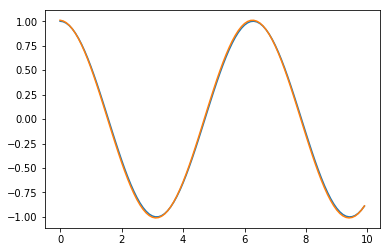

In [6]:
env.reset()
t_space = np.arange(100) / 10
points = [env._system_model(env.m, env.delta, env.big_omega, t) for t in t_space]
# system
plt.plot(t_space, env.get_seq_x(t_space))
# model
plt.plot(t_space, points)
plt.show()

# CE

from https://github.com/udacity/deep-reinforcement-learning/blob/master/cross-entropy/CEM.ipynb

In [7]:
import gym
import math
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# env = gym.make('MountainCarContinuous-v0')
env.seed(101)
np.random.seed(101)

print('observation space:', env.observation_space)
print('action space:', env.action_space)
print('  - low:', env.action_space.low)
print('  - high:', env.action_space.high)

class Agent(nn.Module):
    def __init__(self, env, h_size=16):
        super(Agent, self).__init__()
        self.env = env
        # state, hidden layer, action sizes
        self.s_size = env.observation_space.shape[0]
        self.h_size = h_size
        self.a_size = env.action_space.shape[0]
        # define layers
        self.fc1 = nn.Linear(self.s_size, self.h_size)
        self.fc2 = nn.Linear(self.h_size, self.a_size)
        
    def set_weights(self, weights):
        s_size = self.s_size
        h_size = self.h_size
        a_size = self.a_size
        # separate the weights for each layer
        fc1_end = (s_size*h_size)+h_size
        fc1_W = torch.from_numpy(weights[:s_size*h_size].reshape(s_size, h_size))
        fc1_b = torch.from_numpy(weights[s_size*h_size:fc1_end])
        fc2_W = torch.from_numpy(weights[fc1_end:fc1_end+(h_size*a_size)].reshape(h_size, a_size))
        fc2_b = torch.from_numpy(weights[fc1_end+(h_size*a_size):])
        # set the weights for each layer
        self.fc1.weight.data.copy_(fc1_W.view_as(self.fc1.weight.data))
        self.fc1.bias.data.copy_(fc1_b.view_as(self.fc1.bias.data))
        self.fc2.weight.data.copy_(fc2_W.view_as(self.fc2.weight.data))
        self.fc2.bias.data.copy_(fc2_b.view_as(self.fc2.bias.data))
    
    def get_weights_dim(self):
        return (self.s_size+1)*self.h_size + (self.h_size+1)*self.a_size
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.tanh(self.fc2(x))
        return x.cpu().data
        
    def evaluate(self, weights, gamma=1.0, max_t=5000):
        self.set_weights(weights)
        episode_return = 0.0
        state = self.env.reset()
        for t in range(max_t):
            state = torch.from_numpy(state).float().to(device)
            action = self.forward(state)
            state, reward, done, _ = self.env.step(action)
            episode_return += reward * math.pow(gamma, t)
            if done:
                break
        return episode_return
    
agent = Agent(env).to(device)

observation space: Box(3,)
action space: Box(3,)
  - low: [ 0.  -2.  -0.1]
  - high: [10.   2.   0.1]


/home/dev/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Could not seed environment <PendulumEnv instance>
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


/home/dev/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode 10	Average Score: -134.30
action:
Episode 20	Average Score: -152.61
action:
Episode 30	Average Score: -153.24
action:
Episode 40	Average Score: -177.18
action:
Episode 50	Average Score: -186.65
action:
Episode 60	Average Score: -175.52
action:
Episode 70	Average Score: -156.24
action:
Episode 80	Average Score: -142.57
action:
Episode 90	Average Score: -130.04
action:
Episode 100	Average Score: -118.85
action:


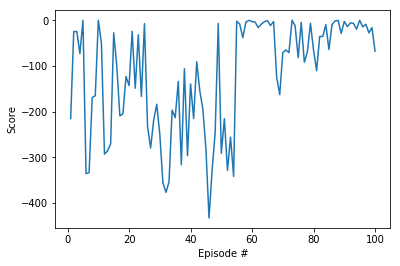

In [9]:
def cem(n_iterations=100, max_t=1000, gamma=1.0, print_every=10, pop_size=50, elite_frac=0.2, sigma=0.5):
    """PyTorch implementation of the cross-entropy method.
        
    Params
    ======
        n_iterations (int): maximum number of training iterations
        max_t (int): maximum number of timesteps per episode
        gamma (float): discount rate
        print_every (int): how often to print average score (over last 100 episodes)
        pop_size (int): size of population at each iteration
        elite_frac (float): percentage of top performers to use in update
        sigma (float): standard deviation of additive noise
    """
    n_elite=int(pop_size*elite_frac)

    scores_deque = deque(maxlen=100)
    scores = []
    best_weight = sigma*np.random.randn(agent.get_weights_dim())

    for i_iteration in range(1, n_iterations+1):
        weights_pop = [best_weight + (sigma*np.random.randn(agent.get_weights_dim())) for i in range(pop_size)]
        rewards = np.array([agent.evaluate(weights, gamma, max_t) for weights in weights_pop])

        elite_idxs = rewards.argsort()[-n_elite:]
        elite_weights = [weights_pop[i] for i in elite_idxs]
        best_weight = np.array(elite_weights).mean(axis=0)

        reward = agent.evaluate(best_weight, gamma=1.0)
        scores_deque.append(reward)
        scores.append(reward)
        
        torch.save(agent.state_dict(), 'checkpoint.pth')
        
        if i_iteration % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_iteration, np.mean(scores_deque)))
            print('action:', )

        if np.mean(scores_deque)>=90.0:
            print('\nEnvironment solved in {:d} iterations!\tAverage Score: {:.2f}'.format(i_iteration-100, np.mean(scores_deque)))
            break
    return scores

scores = cem()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [10]:
# load the weights from file
agent.load_state_dict(torch.load('checkpoint.pth'))

state = env.reset()
while True:
    state = torch.from_numpy(state).float().to(device)
    with torch.no_grad():
        action = agent(state)
    env.render()
    next_state, reward, done, _ = env.step(action)
    state = next_state
    if done:
        break

env.close()

states
 [[1.   1.   0.01]
 [1.   1.   0.01]
 [1.   1.   0.01]
 [1.   1.   0.01]
 [1.   1.   0.01]
 [1.   1.   0.01]
 [1.   1.   0.01]
 [1.   1.   0.01]
 [1.   1.   0.01]
 [1.   1.   0.01]]
actions
 [tensor([ 1.0000, -0.3597, -0.9961]), tensor([ 1.0000, -0.3597, -0.9961]), tensor([ 1.0000, -0.3597, -0.9961]), tensor([ 1.0000, -0.3597, -0.9961]), tensor([ 1.0000, -0.3597, -0.9961]), tensor([ 1.0000, -0.3597, -0.9961]), tensor([ 1.0000, -0.3597, -0.9961]), tensor([ 1.0000, -0.3597, -0.9961]), tensor([ 1.0000, -0.3597, -0.9961]), tensor([ 1.0000, -0.3597, -0.9961])]


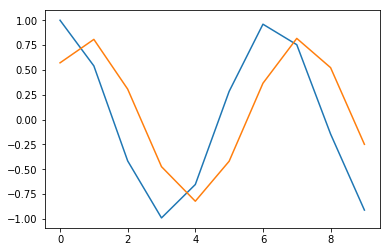

In [11]:
env.reset()
t_space = np.arange(10)#, step=0.1)
expected_points = env.get_seq_x(t_space)
states = env.get_seq_states(t_space)
actions = []
for s in states:
    state = torch.from_numpy(s).float().to(device)
    with torch.no_grad():
        action = agent(state)
        actions.append(action)
print("states\n", states)
print("actions\n", actions)
points = [env._system_model(a[0], a[1], a[2], t) for a, t in zip(actions, t_space)]



plt.plot(t_space, expected_points)
plt.plot(t_space, points)
plt.show()